In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from astropy.io import fits
from ipywidgets import interact

In [2]:
#Load in the best-performing models
ae_model = torch.load("models/ae_20supi6u_CPU.h5") 
RandomForestRegressor = torch.load("models/RFR_20supi6u.h5") 
RandomForestClassifier = torch.load("models/RFC_allnewmodels.h5")

/Users/zoietelkamp/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/zoietelkamp/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
#Load in HST PSF
hdul = fits.open("result00_psf.fits")
psf = hdul[0].data

In [4]:
#Use a GPU if available and a CPU if not
device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu") 

In [5]:
def gen_ML_img(log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_sett, inc):
    """ 
    Generate an image from a set of physical parameters, using machine learning
    
    Parameters
    ----------
    log_mdust: log of dust mass (Solar Masses)
    log_Rc: log of critical radius (Au)
    f_exp: flaring exponent
    H0: scale height (Au)
    log_Rin: log of inner radius (Au)
    sd_exp: surface density exponent
    log_sett: log of dust settling, i.e. alpha viscosity (Microns)
    inc: inclination (Degrees)
    
    Returns
    -------
    image
        generated image
    """
    
    #Predict whether or not the disk corresponding to the inputted
    #parameters will be classified as edge-on
    edge_on=RandomForestClassifier.predict([[log_mdust, log_Rc, f_exp, H0, log_Rin, 
                                             sd_exp, log_sett, inc]])
    if edge_on==1:
        
        #Predict latent space parameters from physical parameters
        z = np.array(RandomForestRegressor.predict([[log_mdust, log_Rc, f_exp, H0, 
                                                     log_Rin, sd_exp, log_sett, inc]]))
        #Convert to float array, make it a pytorch array
        z_torch = torch.from_numpy(z).float()
        #Port the array to GPU if available
        z_gpu = z_torch.to(device=device) 
        #Use the decoder of the autoencoder model to predict the image
        #from the latent space vector
        x = ae_model.decode(z_gpu) 
        #Port array to CPU if not already there
        x = x.to(device='cpu')
        x = x.detach().numpy() 
        #Reshape image
        image = x[0,0,:,:]
        
    elif edge_on==0:
        #Return the PSF if parameters correspond to a non-edge-on image
        image = psf
    
    return image

# Generate an image

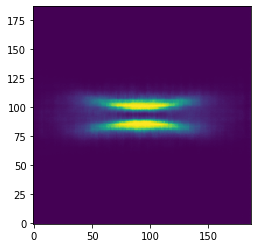

In [8]:
#set the physical parameter values
dust_mass = 5.95e-04
Rc = 264 
flaring_exp = 1.219
H0 = 12.
Rin = 2.1 
sd_exp = -1.38
sett = 2e-3 
inc = 90.0 

#generate and plot the image
img = gen_ML_img(np.log10(dust_mass), np.log10(Rc), flaring_exp, H0,
                 np.log10(Rin), sd_exp, np.log10(sett), inc)

plt.imshow(np.sqrt(img), origin='lower')
plt.show()

# Interactive Widget

In [6]:
def plot_img_widget(log_mdust, log_Rc, f_exp, H0, log_Rin, sd_exp, log_sett, inc):
    
    """ 
    Generate and plot an image from a set of physical parameters
    """
    img = gen_ML_img(log_mdust, log_Rc, f_exp, H0, 
                    log_Rin, sd_exp, log_sett, inc)

    plt.imshow(np.sqrt(img), origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [7]:
#Define parameter limits and increment size and create widget
ML_image = interact(plot_img_widget, log_mdust = (np.log10(1.5e-07), np.log10(0.0012)), 
                    log_Rc=(1,2.477,0.1), f_exp=(1,1.3,0.01), H0=(5,25,1), log_Rin=(-1,1,0.1),
                    sd_exp=(-1.5,0,0.1), log_sett=(np.log10(3e-6),np.log10(3e-3)), 
                    inc = (45,90,1))

interactive(children=(FloatSlider(value=-4.872363747448347, description='log_mdust', max=-2.9208187539523753, …